### Importing the Libraries

In [171]:
# Load essential libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import glob,string
import codecs
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset



In [172]:

path = 'coil-100/*.png'
files=glob.glob(path)

In [173]:
def contructDataframe(file_list):
    """
    this function builds a data frame which contains 
    the path to image and the tag/object name using the prefix of the image name
    """
    data=[]
    for file in tqdm(file_list):
        data.append((file,file.split("/")[-1].split("__")[0]))
    return pd.DataFrame(data,columns=['path','label'])



In [174]:
df_coil100 = contructDataframe(files)

# checking the shape of the image 
img = plt.imread(df_coil100.path[0])
img.shape

100%|██████████| 7200/7200 [00:00<00:00, 121736.74it/s]


(128, 128, 3)

In [175]:
class CreateDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = plt.imread(img_path)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        

        return image, label


In [201]:
from PIL import Image

class CreateDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = plt.imread(img_path)
        label = self.dataframe.iloc[idx, 1]

        # Convert numpy array to PIL Image
#        if self.transform:
##            if isinstance(image, np.ndarray):
 #               image = Image.fromarray((image * 255).astype(np.uint8)) if image.max() <= 1.0 else Image.fromarray(image.astype(np.uint8))
 #           image = self.transform(image)
            
        image = Image.open(img_path).convert("RGB")  # säkerställ 3 kanaler
        if self.transform:
            image = self.transform(image)
            


        return image, label

In [232]:
normalize = transforms.Normalize(
    mean=[0.3443, 0.3809, 0.4082],
    std=[0.1832, 0.1559, 0.1455]
)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    normalize,
])

dataset_coil100 = CreateDataset(df_coil100, transform=transform)

In [233]:
classes = dataset_coil100


# --- Define split sizes ---
dataset_coil100_size = len(dataset_coil100)   
train_size = int(0.7 * dataset_coil100_size)   # 70%
val_size   = int(0.15 * dataset_coil100_size)  # 15%
test_size  = dataset_coil100_size - train_size - val_size  # rest

# --- Split dataset ---
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset_coil100,
    [train_size, val_size, test_size]
)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [223]:
len(dataset_coil100), len(train_dataset), len(val_dataset), len(test_dataset)

(7200, 5040, 1080, 1080)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8054981..3.6900206].


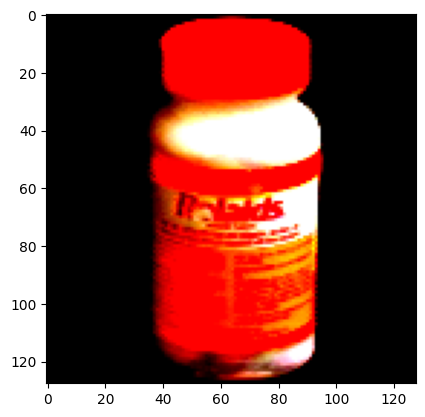

In [234]:
images, labels = next(iter(train_loader))

train_dataset[0]
plt.imshow(images[0].permute(1, 2, 0).numpy())



### Loading the Dataset

In [181]:
def get_train_valid_loader(data_dir, batch_size, percent_train=0.8, shuffle=True, random_seed=42):
    # Define transforms (resize + normalization) ---
    normalize = transforms.Normalize(
        mean=[0.3443, 0.3809, 0.4082],
        std=[0.1832, 0.1559, 0.1455]
    )

    transform = transforms.Compose([
        transforms.Resize((72, 72)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    # load the dataset
    dataset = datasets.EuroSAT(root=data_dir, download=True, transform=transform,)
    print(type(dataset))
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   # ~27,000 images
    train_size = int(percent_train * dataset_size)   # 70%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  # rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  # reproducible
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return (train_loader, valid_loader, test_loader, classes)


In [182]:
# load EuroSAT dataset
train_loader, valid_loader, test_loader, classes = get_train_valid_loader(data_dir = './data',batch_size = 32, percent_train=0.8)


<class 'torchvision.datasets.eurosat.EuroSAT'>


### Visualize images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.821892..2.4604132].


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

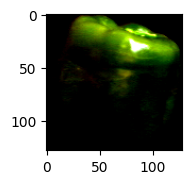

In [235]:
# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

# Denormalize helper
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization
    return img

# Plot some images
def plot_images(images, labels, classes, preds=None, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(int(np.sqrt(num_images)), int(np.ceil(num_images/np.sqrt(num_images))), i+1)
        img = images[i]
        img = denormalize(img)
        npimg = img.permute(1, 2, 0).numpy()
        plt.imshow(npimg)
      
        true_label = classes[labels[i]]
        if preds is not None:
            pred_label = classes[preds[i]]
            title = f"True label: {true_label}\nPredicted label: {pred_label}"
            color = "green" if labels[i] == preds[i] else "red"
            plt.title(title, color=color, fontsize=9)
        else:
            plt.title(f"True label: {true_label}", fontsize=9)

    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Get one batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

plot_images(images, labels, classes, num_images=10)

In [ ]:
# Get one batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)
plot_images(images, labels, classes, num_images=10)

In [185]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # TODO: implement your CNN architecture as defined in the instructions
        pass
        

    def forward(self, x):
        # Complete the forward pass function for the CNN
        pass
        


In [186]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaseCNN(num_classes=10).to(device)

criterion = # TODO: define your loss criterion

optimizer = # TODO: define your optimizer


SyntaxError: invalid syntax (342205825.py, line 4)

### Train and validate your CNN model

In [ ]:
def train(model, train_loader, valid_loader, num_epochs=10):
    train_losses, valid_losses = [], []

    # TODO: Implement training steps
    
    
    # TODO: add training loss of each epoch to the train_losses    
    train_losses.append('''TODO: complete by adding losses here ''')

    print(f"Epoch {epoch+1}, Train Loss: {'''TODO: complete it to print training loss'''):.4f}")

    # Validation
    valid_loss, val_acc = evaluate(model, valid_loader)
    valid_losses.append('''TODO: complete by adding validation losses here ''')

    print(f"Validation Accuracy: {val_acc:.2f}%")

  plot_loss(train_losses, valid_losses)

### Test your model

In [ ]:
def plot_loss(train_losses, val_losses):
    """
    Plot training and validation loss over epochs.

    Args:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [ ]:
# --- Evaluation ---
def evaluate(model, data_loader):    
    # The function can be used for measuring performance on both validation and test datasets
    # The function should return two estimations: loss and accuracy 

    #TODO: complete the function. 
    

    return losses, accuracy 


Epoch 1, Train Loss: 1.6539
Validation Accuracy: 57.56%
Epoch 2, Train Loss: 1.4154
Validation Accuracy: 62.57%
Epoch 3, Train Loss: 1.3309
Validation Accuracy: 53.68%
Epoch 4, Train Loss: 1.2879
Validation Accuracy: 67.78%
Epoch 5, Train Loss: 1.2103
Validation Accuracy: 72.86%
Epoch 6, Train Loss: 1.1713
Validation Accuracy: 73.14%
Epoch 7, Train Loss: 1.1349
Validation Accuracy: 76.52%
Epoch 8, Train Loss: 1.1106
Validation Accuracy: 75.33%
Epoch 9, Train Loss: 1.0717
Validation Accuracy: 78.81%
Epoch 10, Train Loss: 1.0510
Validation Accuracy: 77.43%


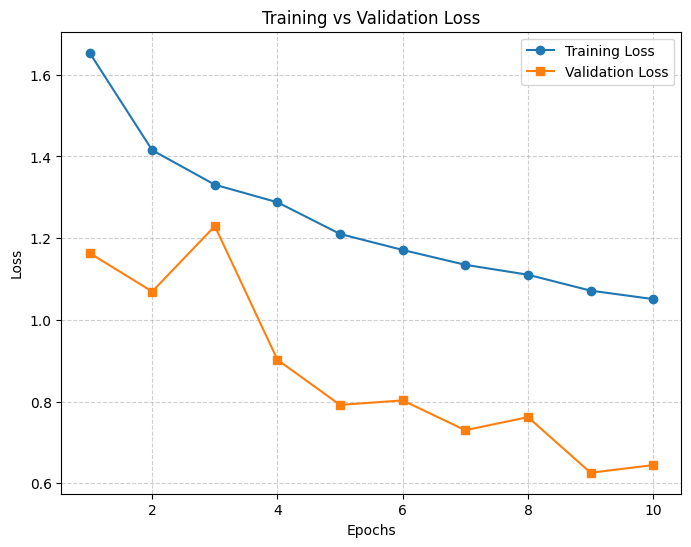

Test Accuracy: 75.85%


In [ ]:
# --- Run training ---
train(model, train_loader, valid_loader, num_epochs=10)

# --- Test accuracy ---
_,test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

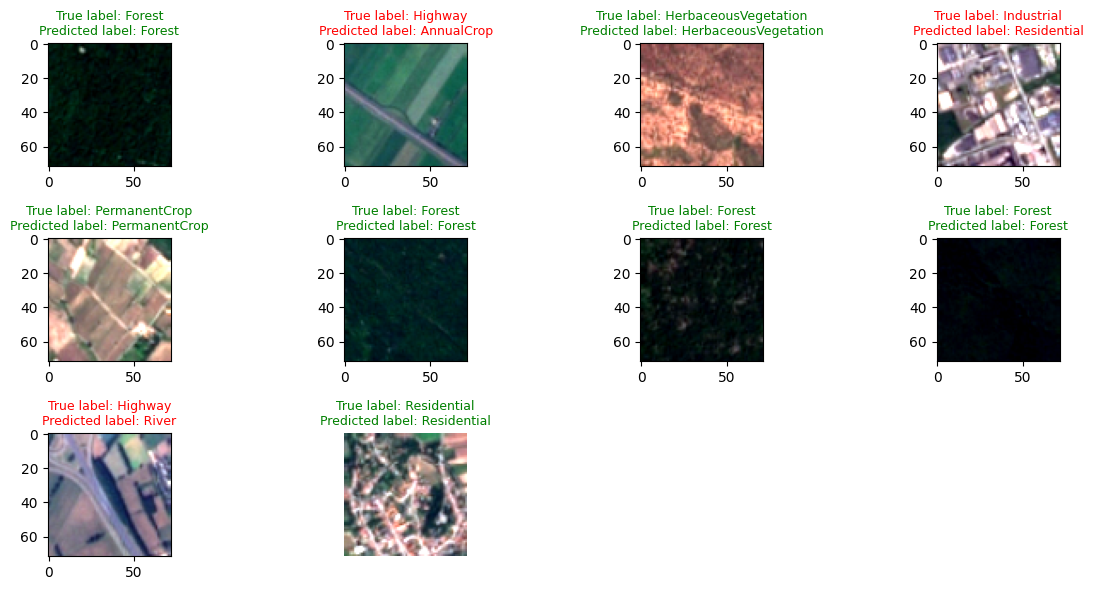

In [ ]:
# Show test images with predictions
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plot_images(images.cpu(), labels, classes, preds=preds.cpu(), num_images=10)


### Provide your answers to Experiment and Reflection

- What choices affect the model's accuracy?
- How do you determine whether the model is  overfitting or underfitting?
- What happens when you add or remove components, for example, dropout or batch normalization?
- What layer causes the highest number of parameters?
- what happens if you remove all pooling layers in a CNN?
- In a CNN block, can you arrange the layer (i.e. Conv, ReLU, BatchNorm, Dropout) in any order? Explain your answer.